This code is used to split the data

In [2]:
import json
import numpy as np
import os

scene_list_file = '/ssddata/yliugu/Segment-Anything-NeRF/scene_list.json'
scene_root = '/ssddata/yliugu/data'
with open(scene_list_file) as f:
    scene_dict = json.load(f)
scene_list = []
for k in list(scene_dict.keys()):
    scene_list.extend(scene_dict[k])
for s in scene_list:
    cur_scene_root = os.path.join(scene_root, s) 
    cur_img_root = os.path.join(cur_scene_root, 'images')
    all_img_list = os.listdir(cur_img_root)
    all_img_list.sort()
    
    skip = 3
    if len(all_img_list) > 200:
        skip = 2
    val_list = all_img_list[::skip]
    train_list = [i for i in all_img_list if i not in val_list]
    if len(train_list) < 50:
        val_list = all_img_list
        train_list = all_img_list
    data_split = {
        'train': train_list,
        'test': val_list
    }
    with open(os.path.join(cur_scene_root, 'data_split.json'), '+w') as f:
        json.dump(data_split, f, indent=4)
        
    

This code is used to splite data into eval and train.

In [ ]:
import os.path as path
import os
import glob
scene_path = '/ssddata/yliugu/Segment-Anything-NeRF/scene_list.json'
metadata_path = '/ssddata/yliugu/Segment-Anything-NeRF/scenes_metadata.json'
workspace_root = '/ssddata/yliugu/trial_model_final/sam_nerf'
data_root = '/ssddata/yliugu/data'
scene_root = '/ssddata/yliugu/data'
scene_list = []
with open(metadata_path) as f:
    meta = json.load(f)

scene_list = list(meta.keys())
scene_list = ["bonsai"]
for scene_name in scene_list:
    split_path = path.join(data_root, scene_name, 'data_split.json')
    for object_name in list(meta[scene_name].keys()):
        

This code is used to select evaluation views automatically.

In [40]:
import json
import os
import os.path as path
import random
meta_path = '/ssddata/yliugu/Segment-Anything-NeRF/scenes_metadata_v2.json'
with open(meta_path) as f:
    meta = json.load(f)

data_root = '/ssddata/yliugu/data'
name = 'replica_room_0'
eval_num = 8
with open(path.join(data_root, name, 'eval_pose.json')) as f:
    eval_json = json.load(f)
image_names = os.listdir(path.join(data_root, name, 'images_4'))
print(len(image_names))
# for i in image_names:
#     if i[:4] != "DSCF":
#         image_names.remove(i)
        
        
        
key_list = list(eval_json.keys())
for i in key_list:
    auto = eval_json[i]['auto'] if 'auto' in key_list else [] 
    # load valid indices
    with open(path.join(data_root, name, f'train_{i}_nerf', 'valid.json')) as f:
        valid_indices = json.load(f)

    # print(list(valid_indices.keys()))
    # print(image_names[0][:-4])
    key_img_names = [n for n in image_names if n[:-4] in list(valid_indices.keys()) and valid_indices[n[:-4]] == 1]        
        
    for j in range(eval_num - len(eval_json[i]['select'])- len(auto)):
        s = None
        while s in eval_json[i]['select'] or s in auto or s is  None:
            s = random.choice(key_img_names)[:-4]
        auto.append(s)
    eval_json[i]['auto'] = auto

with open(path.join(data_root, name, 'eval_pose.json'), 'w+') as f:
    json.dump(eval_json, f, indent = 4)

FileNotFoundError: [Errno 2] No such file or directory: '/ssddata/yliugu/data/3dfront_0019_00/eval_pose.json'

The code is used to create evalutation sets 

In [68]:
import json
import os
import os.path as path
import random
import glob
import cv2
meta_path = '/ssddata/yliugu/Segment-Anything-NeRF/scenes_metadata_v2.json'
with open(meta_path) as f:
    meta = json.load(f)

data_root = '/ssddata/yliugu/data'
name = 'replica_room_0'
object_name = 'sofa'

with open(path.join(data_root, name, f'train_{object_name}_nerf', 'data_split.json')) as f:
    eval_json = json.load(f)


sam_root = path.join('/ssddata/yliugu/trial_model_final/sam_nerf', name)
ckpt_path = path.join(sam_root, 'checkpoints')
checkpoint_list = sorted(glob.glob(f'{ckpt_path}/*.pth'))
latest = path.basename(checkpoint_list[-1])
epoch = latest[-8:-4]


for img_name in list(eval_json['test']):
    target_root = path.join(data_root, name, f'eval_{object_name}')
    os.makedirs(target_root,  exist_ok=True)

    target_path = path.join(target_root, f'ori_{img_name}.png')
    img_path = path.join(sam_root, 'validation', f'ngp_ep{epoch}_{img_name}_rgb.png')
    img = cv2.imread(img_path)
    cv2.imwrite(target_path, img)
        
        
        
        

The code is for get the gt

In [7]:
from segment_anything_hq import SamPredictor, sam_model_registry_baseline
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
import os

# os.environ['CUDA_VISIBLE_DEVICES'] = '3'
import os.path as path
import json
import time
import segmentation_refinement as refine
refiner = refine.Refiner(device='cuda:3') # device can also be 'cpu'

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    
sam = sam_model_registry_baseline["vit_h"](checkpoint="/ssddata/yliugu/Segment-Anything-NeRF/pretrained/sam_vit_h_4b8939.pth").to('cuda:3')
predictor = SamPredictor(sam)



/home/yliugu/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


frame_00240


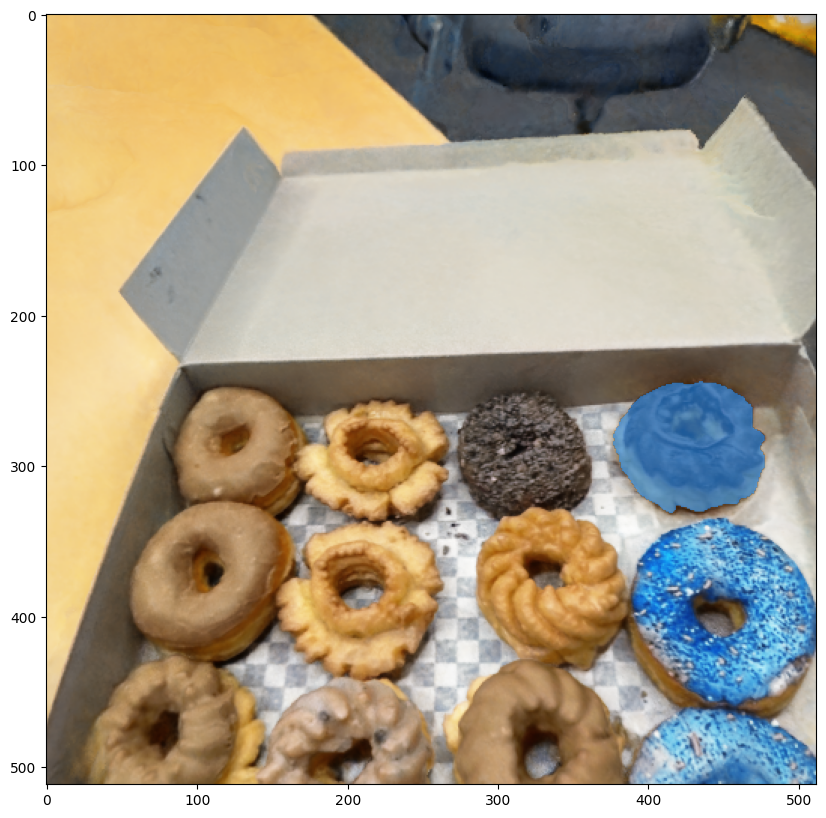

In [5]:
import cv2
data_root = '/ssddata/yliugu/data'
name = 'donuts'
key = 'donut_1'

img_index = 9


eval_json_path = os.path.join(data_root, name, f'train_{key}_nerf', 'data_split.json')
with open(eval_json_path) as f:
    eval_dict = json.load(f)

target_root = path.join(data_root, name, f'eval_{key}')

image_names = eval_dict['test']
    
print(image_names[img_index])
image = cv2.imread(path.join(target_root, 'ori_'+image_names[img_index]+'.png'))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# input_mask = np.load(path.join(data_root, name, f'train_{key}_sam', image_names[img_index]+'_masks.npy'))
input_mask = cv2.imread(path.join(target_root, 'refined_mask_'+image_names[img_index]+'.png')) /255
# plt.figure(figsize=(10,10))
# plt.imshow(image)
# show_mask(input_mask[...,0], plt.gca())
# # show_box(input_box, plt.gca())
# plt.axis('on')
# plt.show() 
# plt.close() 


input_mask = (input_mask * 255).astype(np.int64)
new_input = np.zeros([input_mask.shape[0],input_mask.shape[1], 3])
new_input[..., 0] =input_mask[..., 0]
new_input[..., 1] =input_mask[..., 0]
new_input[..., 2] =input_mask[..., 0]
new_input = new_input.astype('uint8')


# mask_0 = cv2.imread(path.join(target_root, 'mask_'+image_names[img_index]+'.png'))
# new_input = (new_input > 128) + (mask_0 > 128)
# new_input = (new_input>0)*255
# cv2.imwrite(path.join(target_root, 'mask_'+image_names[img_index]+'.png'), new_input)


plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(new_input[...,0] > 0, plt.gca())
# show_box(input_box, plt.gca())

plt.axis('on')
plt.show() 
plt.close() 
new_input = new_input.astype('uint8')

new_input = cv2.resize(new_input, dsize=(256,256))
new_input = new_input[..., 0] / 255 * 10


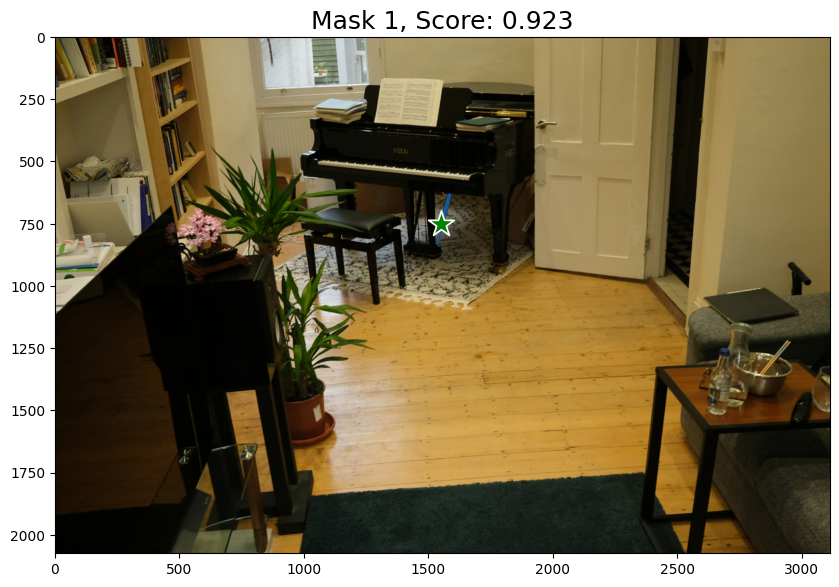

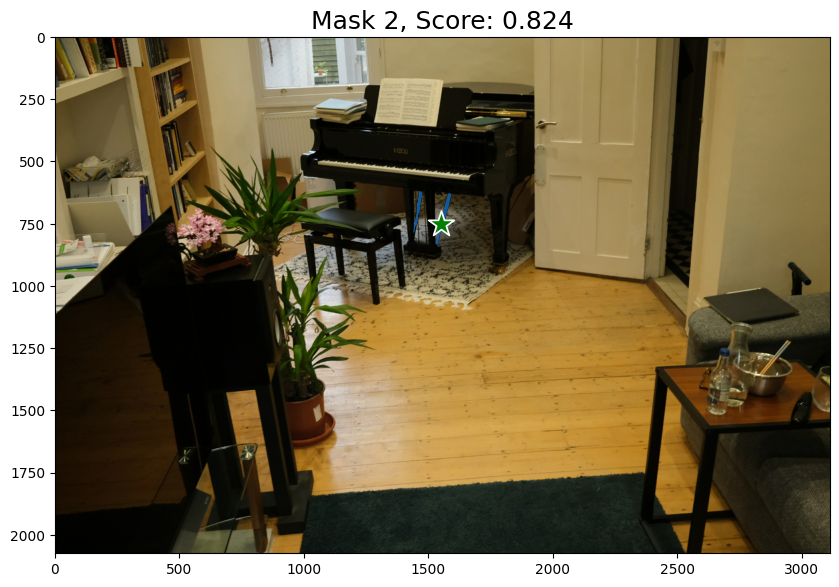

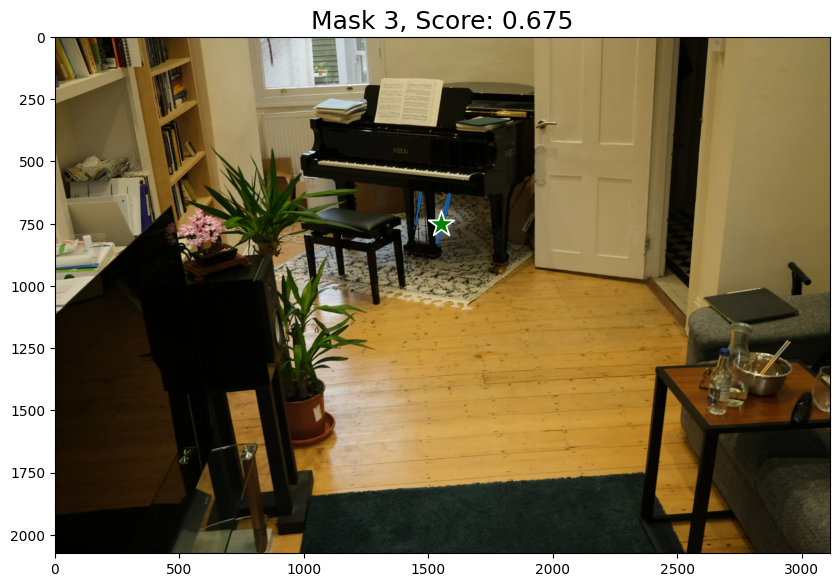

In [18]:

# predictor.set_image(input_mask.astype(np.uint8))
image = cv2.imread('/ssddata/yliugu/selected_masks/room/piano/DSCF4732.png')
predictor.set_image(image)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# input_point = np.array([[270,180],
#                         [200,280]])
# input_point = np.array([[170,420],
#                         [300,420],
#                         [200,280]])
# input_point = np.array([[250,240],
#                         [250,310],])
input_point = np.array([
                        # [180,300],
                        # [250,300],
                        # [120,360]
                        
                      
                        # [130,100],
                        # [110,10]
                        
                        # [150,450]
                        # [380, 320],
                        [1550, 750],
                        # [1750, 200],
                        # [510, 30],
                        # [300,300]
                        
             
                        # [330,350]
                        # [200,200]
                        # [500,400],
                        # [380,280]
                        
                        ])
input_label = np.ones([input_point.shape[0]])
# input_label[0] = 1

masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    # mask_input=new_input[None,...],
    multimask_output=True,
)


mask = masks[2] * 255

# mask = ((masks[0] + input_mask) > 1 ) * 255 
cv2.imwrite('/ssddata/yliugu/selected_masks/room/piano/DSCF4732_mask_5.png', mask)

# mask = np.ones_like(mask[0])
# cv2.imwrite(path.join(target_root, 'mask_'+image_names[img_index]+'.png'), mask)
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    # show_box(input_box, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('on')
    plt.show() 
    


0_0869


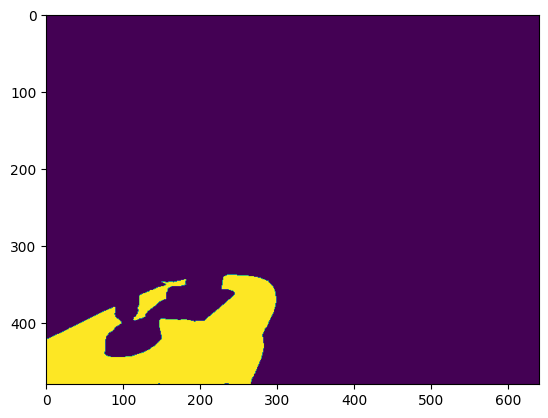

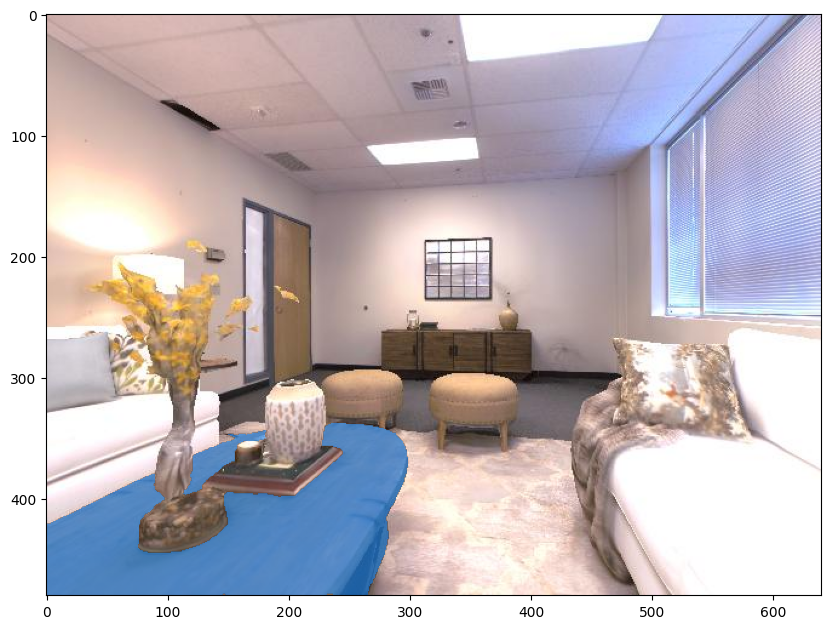

True

In [15]:
# img_index = 0

image = cv2.imread(path.join(target_root, 'ori_'+image_names[img_index]+'.png'))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

print(image_names[img_index])
mask = cv2.imread(path.join(target_root, 'mask_'+image_names[img_index]+'.png'), cv2.IMREAD_GRAYSCALE)
# mask = cv2.imread(path.join(target_root, 'refined_mask_'+image_names[img_index]+'.png'), cv2.IMREAD_GRAYSCALE)


# mask = mask * 255

output = refiner.refine(image, mask, fast=False, L=900) 
output = (output > 128) * 255
plt.imshow(output)
plt.show()
plt.close()


plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(output / 255, plt.gca())
plt.show() 
plt.close() 

np.save(path.join(target_root, 'refined_mask_'+image_names[img_index]+'.npy'), output)
cv2.imwrite(path.join(target_root, 'refined_mask_'+image_names[img_index]+'.png'), output)


This code is used to denoise

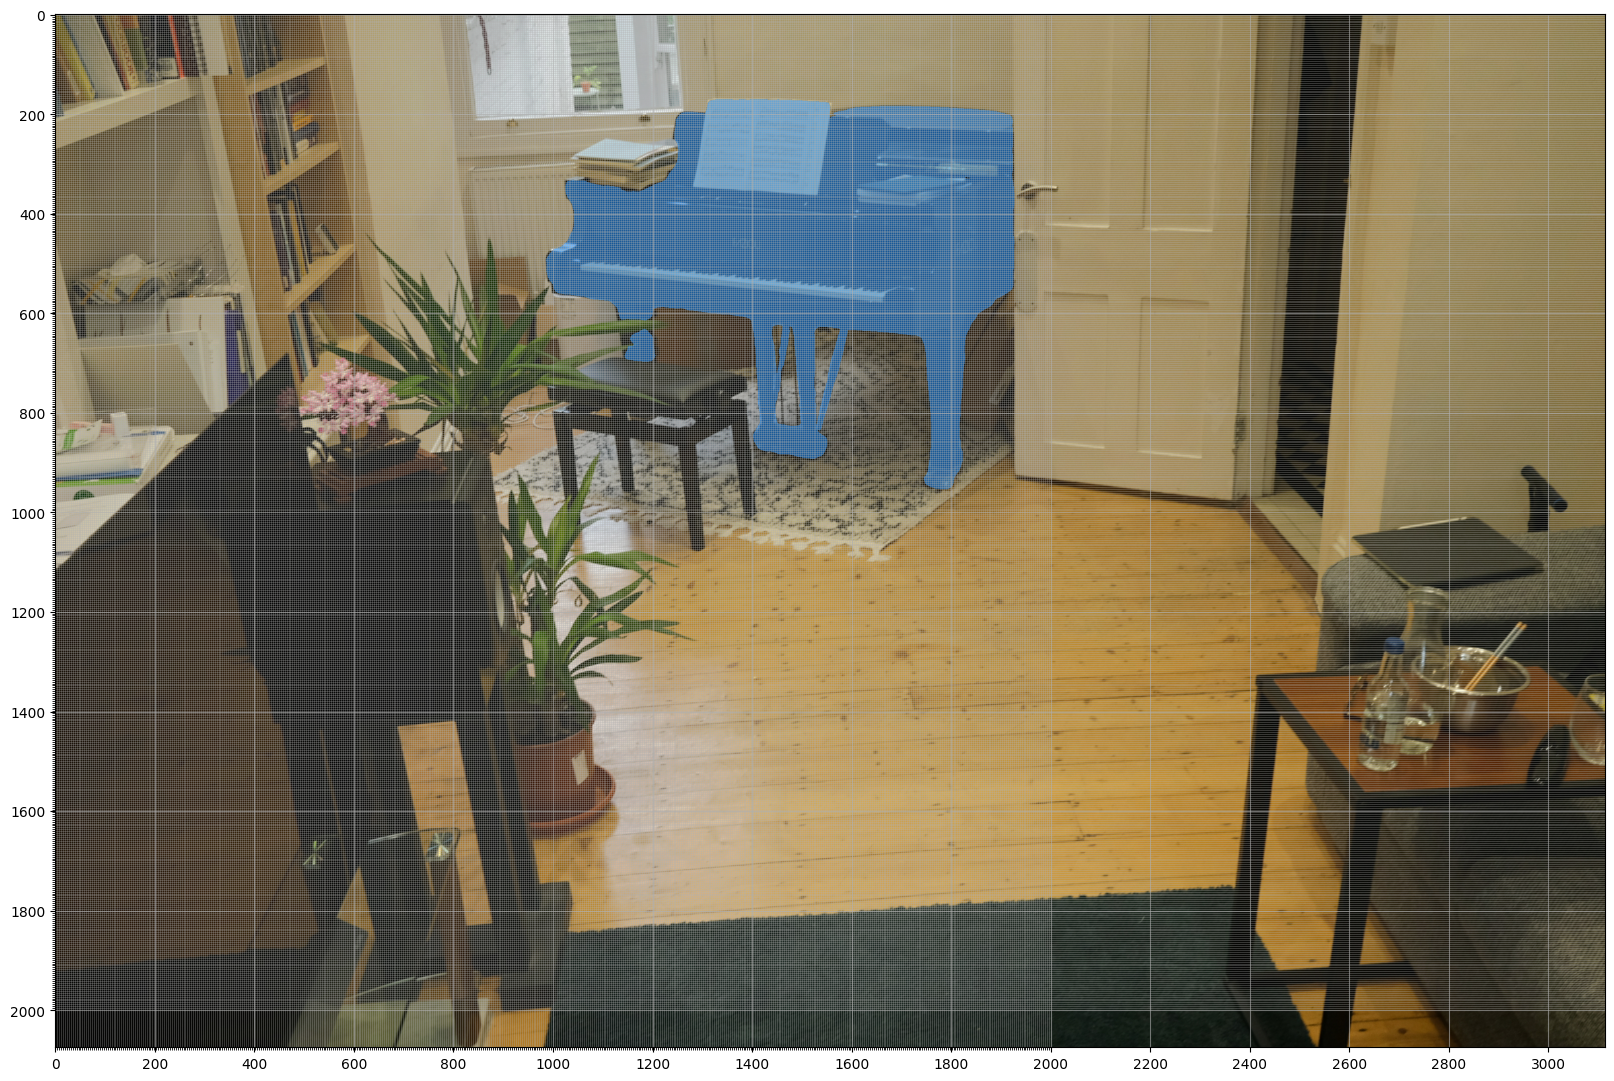

True

In [21]:
# img_name = path.join(target_root, 'mask_'+image_names[img_index]+'.png')
# img_name = path.join(target_root, 'refined_mask_'+image_names[img_index]+'.png')
# img_name = path.join(target_root, 'refined_mask_'+'DSC07973'+'.png')
image = cv2.imread('/ssddata/yliugu/selected_masks/room/piano/DSCF4732.png') 
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = image / 255
# a = np.zeros_like(a)
img_name = '/ssddata/yliugu/selected_masks/room/piano/DSCF4732_mask_all.png'
a = cv2.imread(img_name).astype(np.float32)
# a = np.zeros_like(a)



a[800:,:1200] = 0
# a[:,443:] = 0
# a[:,:409] = 0
a[300:400,1600:1800] = 255
# a[170:,520:] = 0
# a[:136,:443] = 0
# a[:170,:430] = 0
# a[:195,:417] = 0
# a[:,:310] = 0

# a[:443,:410] = 0
# a[:410,:443] = 0
# a[:307,:477] = 0
# a[:307,:] = 0
# a[450:512,0:100] = 255
# a[400:455,204:234] = 255


# a = b

# a[190:240,390:443] = 255
# a[200:240,443:490] = 255

# a[255:260,220:230] = 255

# a[120:180, 220:360] = 0
# a[180:235, 250:290] = 0
# a[170:180, 240:280] = 0
# a[185:230, 245:250] = 0
# a[190:225, 240:245] = 0
# a[185:230, 290:295] = 0
# a[190:225, 295:300] = 0

# a[400:440, 240:260] = 0
# a[385:440, 230:244] = 0

# a[194:200, 258:268] = 0
# a[236:243, 293:300] = 0
# a[230:236:, 287:298] = 0

# a[230:236:, 287:298] = np.array([255,0,0])
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20,20))

major_ticks_top = np.linspace(0, 3000, 16)
minor_ticks_top = np.linspace(0, 2000, 513)


axes.set_xticks(major_ticks_top)
axes.set_yticks(major_ticks_top)
axes.set_xticks(minor_ticks_top, minor=True)
axes.set_yticks(minor_ticks_top, minor=True)
axes.grid(which="major", alpha=0.6)
axes.grid(which="minor", alpha=0.3)

plt.imshow(image)
show_mask(a[..., 0] / 255, plt.gca())
plt.show()
plt.close()
img_name = '/ssddata/yliugu/selected_masks/room/piano/DSCF4732_mask.png'
cv2.imwrite(img_name, a)
# np.save(img_name.replace('.png', '.npy'), a[..., 0] / 255)

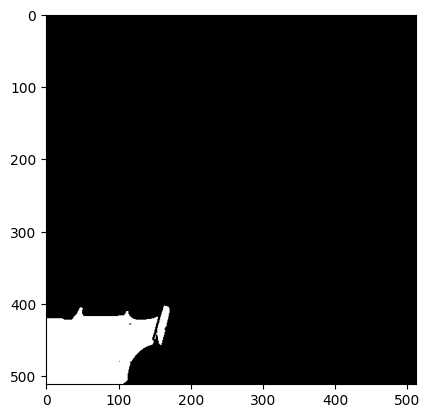

True

In [53]:
img_name = path.join(target_root, 'refined_mask_'+image_names[img_index]+'.png')
a = cv2.imread(img_name)
img_name = path.join(target_root, 'mask_'+image_names[img_index]+'_1.png')

b = cv2.imread(img_name)
temp = a>0 
temp0 =(b > 128)
temp = (temp + temp0) > 0

temp = temp * 255
plt.imshow(temp)
plt.show()
plt.close()
cv2.imwrite(path.join(target_root, 'refined_mask_'+image_names[img_index]+'.png'), temp)

This is used to write the json into data split

In [22]:
import json
import random
import os

with open('scenes_metadata_v2.json') as f:
    meta = json.load(f)
    
data_root = '/ssddata/yliugu/data'

for k in list(meta.keys()):
    k = 'replica_room_0'
    eval_pose_path = os.path.join(data_root, k, 'eval_pose.json')
    if os.path.isfile(eval_pose_path):
        continue
        with open(eval_pose_path) as f:
            eval_pose = json.load(f)
        for o in list(meta[k].keys()):
            eval_dict = {}
            eval_dict['test'] = eval_pose[o]['auto']
            eval_dict['test'].extend(eval_pose[o]['select'])
            with open(os.path.join(data_root, k, f'train_{o}_nerf', 'data_split.json'), '+w') as f:
                json.dump(eval_dict,f, indent=4)
    else:
        
        for o in list(meta[k].keys()):
            
            image_root = os.path.join(data_root, k, f'train_{o}_nerf')
            image_names = [img for img in os.listdir(image_root) if img[-3:] == 'png']
            
            n_img = 10
            if len(image_names) < 80:
                n_img = len(image_names) // 8
            eval_dict = {}
            eval_dict['test'] = []
            for _ in range(n_img):
                s = None
                while s  in eval_dict['test'] or s is None:
                    s = random.choice(image_names)[:-10]
                eval_dict['test'].append(s)
            with open(os.path.join(data_root, k, f'train_{o}_nerf', 'data_split.json'), '+w') as f:
                json.dump(eval_dict,f, indent=4)
           
    break

['0_0422_masks.png', '0_0804_masks.png', '0_0458_masks.png', '0_0786_masks.png', '0_0471_masks.png', '0_0756_masks.png', '0_0895_masks.png', '0_0044_masks.png', '0_0067_masks.png', '0_0586_masks.png', '0_0883_masks.png', '0_0121_masks.png', '0_0382_masks.png', '0_0122_masks.png', '0_0234_masks.png', '0_0612_masks.png', '0_0072_masks.png', '0_0127_masks.png', '0_0815_masks.png', '0_0061_masks.png', '0_0627_masks.png', '0_0506_masks.png', '0_0152_masks.png', '0_0855_masks.png', '0_0646_masks.png', '0_0491_masks.png', '0_0228_masks.png', '0_0554_masks.png', '0_0257_masks.png', '0_0176_masks.png', '0_0818_masks.png', '0_0238_masks.png', '0_0779_masks.png', '0_0407_masks.png', '0_0185_masks.png', '0_0661_masks.png', '0_0003_masks.png', '0_0706_masks.png', '0_0817_masks.png', '0_0392_masks.png', '0_0483_masks.png', '0_0363_masks.png', '0_0172_masks.png', '0_0272_masks.png', '0_0466_masks.png', '0_0114_masks.png', '0_0624_masks.png', '0_0745_masks.png', '0_0245_masks.png', '0_0314_masks.png',

This code is used to rename image names

In [97]:
import os
root = '/ssddata/yliugu/data'
problem_scenes = ['fenceflower',  'colinepiano', 'cecread']

for s in problem_scenes:
    image_root = os.path.join(root, s, 'images')
    img_list = os.listdir(image_root)
    img_list.sort()
    img_list_1 = os.listdir(image_root+'_4')
    img_list_1.sort()
    
    mask_root = os.path.join(root, s, 'masks')
    if os.path.isdir(mask_root):
        print('haha')
        mask_list = os.listdir(mask_root)
        mask_list.sort()
    if len(img_list) == len(img_list_1):
        for i in range(len(img_list)):
            os.rename(os.path.join(image_root, img_list[i]), os.path.join(image_root, f'image{i:03d}'+img_list[i][-4:]))
            if os.path.isdir(mask_root):
                os.rename(os.path.join(mask_root, mask_list[i]), os.path.join(mask_root, f'image{i:03d}'+mask_list[i][-4:]))
   

haha
haha
haha


This code is to create gt segmentation for llff

In [8]:
import os
import json
import cv2
data_root = '/ssddata/yliugu/data'
problem_scenes = ['fortress']
meta_path = '/ssddata/yliugu/Segment-Anything-NeRF/scenes_metadata_v2.json'
with open(meta_path) as f:
    meta = json.load(f)
    
# a = [s for s in meta['llff'] if s not in problem_scenes]


for s in problem_scenes:
    scene_dict = meta[s]
    mask_root = os.path.join(data_root, 'nerf_llff', s, 'masks')
    for o in list(scene_dict.keys()):
        object_dict = os.path.join(data_root, s, f'eval_{o}')
        os.makedirs(object_dict, exist_ok=True)
        
        eval_json_path = os.path.join(data_root, s, f'train_{o}_nerf', 'data_split.json')
        with open(eval_json_path) as f:
            eval_dict = json.load(f)
        all_imgs = os.listdir(mask_root)
        all_imgs.sort()
        for t in eval_dict['test']:
            idx = int(t[-3:])
            mask = cv2.imread(os.path.join(mask_root, all_imgs[idx]))
            cv2.imwrite(os.path.join(object_dict, 'refined_mask_' +t+'.png'), mask)

        eval_dict['use_default_intrinstic'] = 1
        with open(eval_json_path, '+w') as f:
            json.dump(eval_dict, f, indent = 4)
            
    break 
    # image_root = os.path.join(root, s, 'images')
    # img_list = os.listdir(image_root)
    # img_list.sort()
    # img_list_1 = os.listdir(image_root+'_4')
    # img_list_1.sort()
    
    # mask_root = os.path.join(root, s, 'masks')
    # if os.path.isdir(mask_root):
    #     print('haha')
    #     mask_list = os.listdir(mask_root)

This code is to create gt segmentation for 3dfront

In [14]:
import numpy as np
import matplotlib.pyplot as plt 
import os
import json
import cv2
import h5py
color_map = np.multiply([
    plt.cm.get_cmap('gist_ncar', 100)((i * 7 + 5) % 100)[:3] for i in range(100)
], 1)

def show_masks(masks):
    H, W = masks.shape
    masks = masks.reshape(H*W)
    output = np.ones([H* W, 3])
    mask_num = int(np.max(masks))

    for i in range(mask_num):
        instance_id = masks == i
        color_mask = color_map[i]
        output[instance_id] = color_mask
        
    plt.figure(figsize=(5,5))
    plt.imshow(output.reshape([H, W, 3]))

    plt.axis('off')
    plt.show() 
    plt.close() 
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    


/tmp/ipykernel_3074620/3164541388.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.cm.get_cmap('gist_ncar', 100)((i * 7 + 5) % 100)[:3] for i in range(100)


In [64]:
data_root = '/ssddata/yliugu/data'
meta_path = '/ssddata/yliugu/Segment-Anything-NeRF/scenes_metadata_v2.json'
scene_path = '/ssddata/yliugu/Segment-Anything-NeRF/scene_list.json'
mask_root = '/ssddata/yliugu'
with open(meta_path) as f:
    meta = json.load(f)
with open(scene_path) as f:
    all_scenes = json.load(f)
    problem_scenes = all_scenes['3dfront']
    
    
for s in problem_scenes:
    s = '3dfront_0091_00'
    scene_dict = meta[s]
    for o in list(scene_dict.keys()):
        o = 'table'
        inst_id = 3
        object_dict = os.path.join(data_root, s, f'eval_{o}')
        os.makedirs(object_dict, exist_ok=True)
        
        eval_json_path = os.path.join(data_root, s, f'train_{o}_nerf', 'data_split.json')
        with open(eval_json_path) as f:
            eval_dict = json.load(f)
        
        for t in eval_dict['test']:
            filename = os.path.join(mask_root, s, f'{int(t)}.hdf5')
            
            with h5py.File(filename, "r") as f:
                
                seg_mask = np.array(f['cp_instance_id_segmaps']) 
                
                inst_mask = (seg_mask == inst_id) * 255
                cv2.imwrite( os.path.join(object_dict, f'refined_mask_{t}.png'), inst_mask)
                
                unique_id = np.unique(seg_mask)
            #     print(unique_id)
            #     for u in unique_id:
            #         print(u)
            #         show_masks(seg_mask==u)
            
            # break
    #     break
    # break
#             mask = cv2.imread(os.path.join(mask_root, t+'.png'))
#             cv2.imwrite(os.path.join(object_dict, 'refined_mask_' +t+'.png'), mask)

#         eval_dict['use_default_intrinstic'] = 1
#         with open(eval_json_path, '+w') as f:
#             json.dump(eval_dict, f, indent = 4)
            
        
    # image_root = os.path.join(root, s, 'images')
    # img_list = os.listdir(image_root)
    # img_list.sort()
    # img_list_1 = os.listdir(image_root+'_4')
    # img_list_1.sort()
    
    # mask_root = os.path.join(root, s, 'masks')
    # if os.path.isdir(mask_root):
    #     print('haha')
    #     mask_list = os.listdir(mask_root)

This code is to create gt segmentation for lift

In [23]:
import pickle




data_root = '/ssddata/yliugu/data'
meta_path = '/ssddata/yliugu/Segment-Anything-NeRF/scenes_metadata_v2.json'
scene_path = '/ssddata/yliugu/Segment-Anything-NeRF/scene_list.json'
mask_root = '/ssddata/yliugu'
with open(meta_path) as f:
    meta = json.load(f)
with open(scene_path) as f:
    all_scenes = json.load(f)
    problem_scenes = all_scenes['lift']
    
    
for s in problem_scenes:
    s = 'ctr_lift_1'
    scene_dict = meta[s]
    for o in list(scene_dict.keys()):
        o = 'packing_box'
        inst_id = 3
        
        # inst_id_1 = 20
        # table 80
        
        # with open('/ssddata/yliugu/data/replica_room_0/segmentation_data.pkl', 'rb') as f:
        #     data = pickle.load(f)
        # print(data)
        # break
        
        object_dict = os.path.join(data_root, s, f'eval_{o}')
        mask_root = os.path.join(data_root, s, 'instance')
        os.makedirs(object_dict, exist_ok=True)
        
        eval_json_path = os.path.join(data_root, s, f'train_{o}_nerf', 'data_split.json')
        with open(eval_json_path) as f:
            eval_dict = json.load(f)
        
        for t in eval_dict['test']:
            print(t)
            # filename = os.path.join(mask_root, f'{t}.png')
            # seg_mask = cv2.imread(filename)[..., 0]
            
            filename = os.path.join(mask_root, f'{t}.npy')
            seg_mask = np.load(filename)
            
            
            inst_mask = (seg_mask == inst_id) * 255
            # inst_mask_1 = (seg_mask == inst_id_1) * 255
            # inst_mask = inst_mask + inst_mask_1
            cv2.imwrite( os.path.join(object_dict, f'refined_mask_{t}.png'), inst_mask)
            
            
            rgb = cv2.imread(os.path.join(data_root, s, 'images', f'{t}.png'))
            
            cv2.imwrite( os.path.join(object_dict, f'ori_{t}.png'), rgb)
            unique_id = np.unique(seg_mask)
            print(unique_id)
            # for u in unique_id:
            #     print(u)
            #     plt.imshow(rgb)
            #     show_mask(seg_mask == u, plt.gca())
            #     plt.show()
            #     plt.close()
                
            # break
            
            
            
        break
    break
#             mask = cv2.imread(os.path.join(mask_root, t+'.png'))
#             cv2.imwrite(os.path.join(object_dict, 'refined_mask_' +t+'.png'), mask)

#         eval_dict['use_default_intrinstic'] = 1
#         with open(eval_json_path, '+w') as f:
#             json.dump(eval_dict, f, indent = 4)
            
        
    # image_root = os.path.join(root, s, 'images')
    # img_list = os.listdir(image_root)
    # img_list.sort()
    # img_list_1 = os.listdir(image_root+'_4')
    # img_list_1.sort()
    
    # mask_root = os.path.join(root, s, 'masks')
    # if os.path.isdir(mask_root):
    #     print('haha')
    #     mask_list = os.listdir(mask_root)

00106
[ 0  1  2  3  4  5  6  7  8  9 11 12 13 14 15 16 21 27 28 31]
00148
[ 0  1  2  3  4  5  7  8  9 11 12 13 14 15 32]
00388
[ 0  1  2  3  4  6  7  9 11 14 15 16 21 28 31]
00555
[ 0  1  2  3  4  5  6  7  9 11 12 13 14 15 16 21 32]
00205
[ 0  1  2  3  4  6  7  9 10 11 12 14 15 16 19 20 22 25 27 36 39 40 41 44
 45 47 48 49]
00771
[ 0  1  2  3  4  5  7  9 11 13 14 15 17 21 22 25 32]
00444
[ 0  1  2  3  4  5  7  8  9 11 12 13 14 15 16 18 30 32 35 43]
00122
[ 0  1  2  3  4  5  6  9 10 12 13 14 15 16 18 20 21 24 26 27 28 29 31 33
 42 46]
00785
[ 0  1  2  3  4  5  6  7  9 11 12 13 14 15 20 27 28 29]
00043
[ 0  1  2  3  4  5  6  7  9 10 11 12 13 14 15 16 20 21 24 25 27 28 29 32
 33 35 42 46]


In [2]:
import numpy as np
import os
import json
from tqdm import tqdm
import shutil
import os.path as path

os.environ['CUDA_VISIBLE_DEVICES'] = '3'

scene_dict = '/ssddata/yliugu/Segment-Anything-NeRF/scene_list.json'
workspace = '/ssddata/yliugu/trial_model_final'
with open(scene_dict) as f:
    scene_dict = json.load(f)
    


data_root = '/ssddata/yliugu/data'
metadata_path = '/ssddata/yliugu/Segment-Anything-NeRF/scenes_metadata_v2.json'
with open(metadata_path) as f:
    meta = json.load(f)
    
for scene_type in list(scene_dict.keys()):
    
    # scene_type = 'mip'
    scene_list = scene_dict[scene_type]
    
    for scene_name in scene_list:
        
        # scene = 'garden'
        scene_data_root = path.join(data_root, scene_name)

        
        for object_name in meta[scene_name]:
            ending = 'nerf'
            cur_scene_root = os.path.join(data_root, scene_name)
            mask_folder_name = f'train_{object_name}_{ending}'
            
            

(512, 512, 3)
2020.1739130434785


This code is to create ground truths of our dataset

In [2]:
import os
import cv2
import json
import pandas as pd
import glob
import numpy as np

df = pd.read_csv('/ssddata/yliugu/selected_masks/mask_list.csv')


In [3]:
scene_meta_path = '/ssddata/yliugu/Segment-Anything-NeRF/scenes_metadata_v2.json'
scene_list_path = '/ssddata/yliugu/Segment-Anything-NeRF/scene_list.json'
mask_root = '/ssddata/yliugu/selected_masks'
annotation_root ='/ssddata/yliugu/annotation'
data_root = '/ssddata/yliugu/data'
with open(scene_meta_path) as f:
    meta = json.load(f)


with open(scene_list_path) as f:
    scene_list = json.load(f)

data_types = ['mip', 'lerf', 'llff']
for  data_type in data_types:
    cur_scene_list = scene_list[data_type]
    for scene in cur_scene_list:
        print(scene+':')
        print(list(meta[scene].keys()))


bonsai:
['vase']
counter:
['gloves', 'flowerport']
garden:
['table_with_vase', 'table_whole']
kitchen:
['lego']
room:
['chair', 'piano', 'slippers']
teatime:
['sheep']
shoe_rack:
['blue_shoes']
donuts:
['donut_0', 'donut_1', 'donut_2']
espresso:
['coffee_machine']
waldo_kitchen:
['sink', 'blue_bottle']
horns:
['horns']
fern:
['fern']
fenceflower:
['fenceflower']
fortress:
['fortress']
colinepiano:
['human']
cecread:
['human']


In [11]:

data_types = ['llff']
test_view_meta = {}
for data_type in data_types:
    cur_scene_list = scene_list[data_type]
    for scene_name in cur_scene_list:
        
        scene_name = 'fortress'
        print(scene_name+':')
        test_view_meta[scene_name] = {}
        for i, obj_name in enumerate(list(meta[scene_name].keys())):
            i = 0
            obj_name = 'fortress'

            test_view_meta[scene_name][obj_name] = []
            obj_id = i + 1
            cur_scene_mask_root = os.path.join(mask_root, scene_name)
            os.makedirs(cur_scene_mask_root, exist_ok=True)

            cur_obj_mask_root = os.path.join(cur_scene_mask_root, obj_name)
            os.makedirs(cur_obj_mask_root, exist_ok=True)

            obj_json_path = os.path.join(data_root, scene_name, f'train_{obj_name}_nerf', 'data_split.json')
            with open(obj_json_path) as f:
                # print(obj_json_path)
                test_list = json.load(f)
                test_list = test_list['test']

            no_img_list= []
            endings = ['jpg','png','JPG','PNG']
            ending = None
            for l in test_list:
                test_view_meta[scene_name][obj_name].append(l)
                img_name = f'/data/local-files/?d=selected_scenes/{scene_name}/{l}.'
                for e in endings:
                    cur_name = img_name+e
                    match_idx = df.index[df['image'] == cur_name].tolist()
                    if match_idx:
                        ending = e
                        
                        break
                    
                if not match_idx:
                    no_img_list.append(l)
                    continue

                cur_idx = match_idx[0]
                mask_id = df['id'][cur_idx]
                
                # if l == 'frame_00043':
                #     print('yes')
                #     print(match_idx)
                #     print(mask_id)
                search_key_word = os.path.join(annotation_root, f'task-{mask_id}*-obj{obj_id}*')
                
                target_annotations = glob.glob(search_key_word)
                if not target_annotations:
                    print(l)
                    print("haha")
                    continue
                    
                final_mask = cv2.imread(target_annotations[0])[..., 0]
                for ann in target_annotations[1:]:
                    final_mask += cv2.imread(ann)[..., 0]
                
                final_mask = (final_mask > 0) * 255
                save_mask_path = os.path.join(cur_obj_mask_root, f'{l}_mask.png')
                cv2.imwrite(save_mask_path, final_mask)
                
                img = cv2.imread(os.path.join(data_root, scene_name, 'images', l)+f'.{ending}')
                save_img_path = os.path.join(cur_obj_mask_root, f'{l}.png')
                cv2.imwrite(save_img_path, img)
            test_view_meta[scene_name][obj_name].sort()
            print(no_img_list)
            break
        break
    break

            
# with open('/ssddata/yliugu/selected_masks/test_view_json.json', 'w+') as f:
#     json.dump(test_view_meta, f, indent=4)

fortress:


image014
haha
[]


This code is used to copy the remaining scenes

In [36]:
print(scene_list)

remaining_scene_list = ['3dfront_0019_00', '3dfront_0091_00', '3dfront_0089_00', 'scene0423_02', 'replica_room_0', 'ai_001_008', 'ctr_lift_0', 'ctr_lift_1', 'ctr_lift_2']
# remaining_scene_list = ['fenceflower', 'colinepiano', 'cecread']

with open('/ssddata/yliugu/selected_masks/test_view_json.json') as f:
    test_view_meta = json.load(f)

for scene_name in remaining_scene_list:
    print(scene_name+':')
    test_view_meta[scene_name] = {}
    cur_scene_root = os.path.join(data_root, scene_name)
    for i, obj_name in enumerate(list(meta[scene_name].keys())):
        obj_json_path = os.path.join(data_root, scene_name, f'train_{obj_name}_nerf', 'data_split.json')
        with open(obj_json_path) as f:
            # print(obj_json_path)
            test_list = json.load(f)
            test_list = test_list['test']
            
        test_view_meta[scene_name][obj_name] = []
        cur_scene_mask_root = os.path.join(mask_root, scene_name)
        os.makedirs(cur_scene_mask_root, exist_ok=True)
        cur_obj_mask_root = os.path.join(cur_scene_mask_root, obj_name)
        os.makedirs(cur_obj_mask_root, exist_ok=True)
        previous_obj_mask_root = os.path.join(cur_scene_root, f'eval_{obj_name}')
        
        no_img_list= []
        endings = ['jpg','png','JPG','PNG']
        ending = None
        for l in test_list:
            test_view_meta[scene_name][obj_name].append(l)
            img_name = os.path.join(data_root, scene_name, 'images', l)
            for e in endings:
                cur_name = img_name+'.'+e
                
                if os.path.isfile(cur_name):
                    ending = e
                    break
            
            old_mask_path = os.path.join(previous_obj_mask_root, f'refined_mask_{l}.png')
            old_mask = cv2.imread(old_mask_path)
            save_mask_path = os.path.join(cur_obj_mask_root, f'{l}_mask.png')
            cv2.imwrite(save_mask_path, old_mask)
            
            img = cv2.imread(cur_name)
            save_img_path = os.path.join(cur_obj_mask_root, f'{l}.png')
            cv2.imwrite(save_img_path, img)
        test_view_meta[scene_name][obj_name].sort()
            
with open('/ssddata/yliugu/selected_masks/test_view_json.json', 'w+') as f:
    json.dump(test_view_meta, f, indent=4)

{'mip': ['bonsai', 'counter', 'garden', 'kitchen', 'room'], 'lerf': ['teatime', 'shoe_rack', 'donuts', 'espresso', 'waldo_kitchen'], 'llff': ['horns', 'fern', 'fenceflower', 'fortress', 'colinepiano', 'cecread'], '3dfront': ['3dfront_0019_00', '3dfront_0091_00', '3dfront_0089_00'], 'lift': ['scene0423_02', 'replica_room_0', 'ai_001_008', 'ctr_lift_0', 'ctr_lift_1', 'ctr_lift_2']}
3dfront_0019_00:
3dfront_0091_00:


3dfront_0089_00:
scene0423_02:
replica_room_0:
ai_001_008:
ctr_lift_0:
ctr_lift_1:
ctr_lift_2:


In [22]:
mask1 = cv2.imread('task-504-annotation-204-by-2-BrushLabels-obj2-0.png')[..., 0]

mask2 = cv2.imread('task-504-annotation-204-by-2-BrushLabels-obj2-1.png')[..., 0]
final_mask = (mask1+mask2)>0

cv2.imwrite('DSCF4793.png', final_mask)

[ WARN:0@909.992] global loadsave.cpp:248 findDecoder imread_('task-504-annotation-204-by-2-BrushLabels-obj2-0.png'): can't open/read file: check file path/integrity


TypeError: 'NoneType' object is not subscriptable

In [19]:
# combine different masks
import cv2
im_all = cv2.imread('/ssddata/yliugu/selected_masks/room/piano/DSCF4732_mask_3.png')
for i in range(6):
    
    im = cv2.imread(f'/ssddata/yliugu/selected_masks/room/piano/DSCF4732_mask_{i}.png')
    
    im_all += im
    
cv2.imwrite('/ssddata/yliugu/selected_masks/room/piano/DSCF4732_mask_all.png', im_all)

True